# Panel Analysis with County Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS

In [2]:
DATA_DIR = "../data/cleaned-data/"

In [3]:
data = pd.read_csv(DATA_DIR + "countyincome_gini_const.csv")
data.head()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL
0,1989,1001,0.400131,13674.0,31869.0,333060.0,279230.0,3115.0,13269.0,295614.0
1,1989,1003,0.425340,39202.0,86819.0,957370.0,673040.0,24108.0,82778.0,779926.0
2,1989,1005,0.480382,9367.0,21385.0,193510.0,153190.0,2729.0,12946.0,168865.0
3,1989,1007,0.452399,6347.0,15087.0,129680.0,107400.0,924.0,5794.0,114118.0
4,1989,1009,0.419520,13270.0,31010.0,294430.0,241690.0,1984.0,14595.0,258269.0


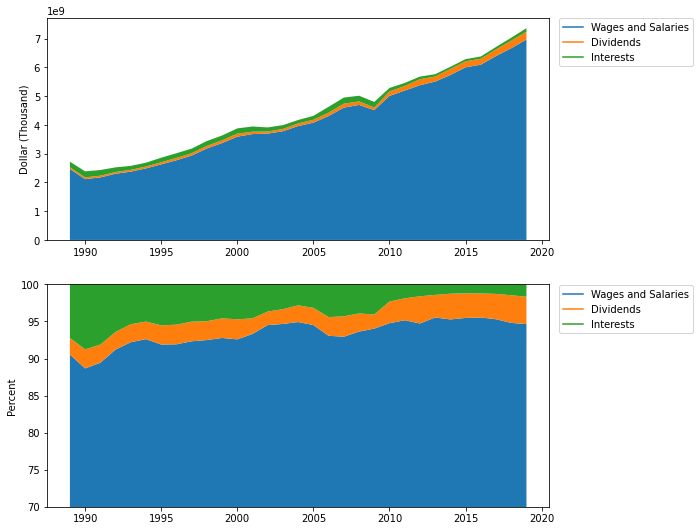

In [52]:
data_mean_by_year = data.groupby("YEAR")[["WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL"]].sum()

fig,(ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(9)
fig.set_figwidth(9)
# Plot x-labels, y-label and data
ax1.plot([], [], color = "tab:blue",
         label ='Wages and Salaries')
ax1.plot([], [], color = "tab:orange",
         label ='Dividends')
ax1.plot([], [], color = "tab:green",
         label ='Interests')
ax1.stackplot(data_mean_by_year.index, data_mean_by_year["WAGES_SALARIES"], data_mean_by_year["DIVIDENDS"], data_mean_by_year["INTEREST"])
ax1.set_ylabel("Dollar (Thousand)")
ax1.legend(loc=(1.02,0.78))

# Plot x-labels, y-label and data
ax2.plot([], [], color = "tab:blue",
         label ='Wages and Salaries')
ax2.plot([], [], color = "tab:orange",
         label ='Dividends')
ax2.plot([], [], color = "tab:green",
         label ='Interests')

WAGES_SALARIES = data_mean_by_year["WAGES_SALARIES"] / data_mean_by_year["TAXABLE_TOTAL"] * 100, 
DIVIDENDS = data_mean_by_year["DIVIDENDS"] / data_mean_by_year["TAXABLE_TOTAL"] * 100, 
INTEREST = data_mean_by_year["INTEREST"] / data_mean_by_year["TAXABLE_TOTAL"] * 100

ax2.stackplot(data_mean_by_year.index, WAGES_SALARIES, DIVIDENDS, INTEREST)
ax2.set_ylabel("Percent")
ax2.legend(loc=(1.02,0.78))
ax2.set_ylim(70, 100)
plt.show()

## Prepare Data

In [4]:
aggregate = pd.DataFrame(data.groupby("YEAR")["TAXABLE_TOTAL"].sum()).reset_index()
aggregate.rename(columns={"TAXABLE_TOTAL": "AGGREGATE_TAXABLE_TOTAL"}, inplace=True)

In [5]:
data = data.merge(aggregate, left_on="YEAR", right_on="YEAR")

In [6]:
data_change = data.sort_values(by=["GEOFIPS", "YEAR"], ascending=True).set_index(["YEAR", "GEOFIPS", "GINI"]).pct_change().reset_index()
data_change = data_change[data_change["YEAR"] > 1989]

In [7]:
cols = ["NUM_RETURN", "NUM_EXEMPT", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL", "AGGREGATE_TAXABLE_TOTAL"]
for col in cols:
    data_change[col] = data_change[col].map(lambda x: x * 100)
data_change.head()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL
1,1990,1001,0.400131,-5.784701,-1.186106,4.633399,5.389822,-22.696629,2.170473,4.949360,-12.328394
2,1991,1001,0.400131,2.708996,2.638849,7.234312,6.115604,19.144518,0.221288,5.959161,1.923938
3,1992,1001,0.400131,1.655079,1.738754,7.157556,7.136613,-0.871384,-14.381394,6.177354,3.807704
4,1993,1001,0.400131,3.940227,3.396789,5.995490,6.145031,15.787623,-14.690965,5.529166,2.022899
5,1994,1001,0.400131,3.018382,1.911708,10.498045,7.161483,7.045247,1.168884,6.998987,4.347252


## Evaluate PanelOLS

In [8]:
def evaluate(data_change, y="TAXABLE_TOTAL", cutoff=0.5, time_effects=True, entity_effects=True, show_result=True):
    gini_ranking = np.array(data_change.groupby("GEOFIPS")["GINI"].mean().sort_values().index)
    high_gini_counties = gini_ranking[round(len(gini_ranking) * cutoff):]
    low_gini_counties = gini_ranking[:round(len(gini_ranking) * cutoff)]
    
    df_high_gini = data_change[data_change["GEOFIPS"].isin(high_gini_counties)].copy()
    df_high_gini["HIGH_GINI"] = np.ones(df_high_gini.shape[0])
    df_low_gini = data_change[data_change["GEOFIPS"].isin(low_gini_counties)].copy()
    df_low_gini["HIGH_GINI"] = np.zeros(df_low_gini.shape[0])
    
    df_merged = pd.concat([df_high_gini, df_low_gini])
    df_merged["AGGREGATE_TAXABLE_TOTAL*HIGH_GINI"] = df_merged["AGGREGATE_TAXABLE_TOTAL"] * df_merged["HIGH_GINI"]
    df_merged.set_index(["YEAR", "GEOFIPS"], inplace=True)
    df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_merged.dropna(inplace=True)
    
    exog = sm.add_constant(df_merged[["AGGREGATE_TAXABLE_TOTAL*HIGH_GINI"]])
    model = PanelOLS(df_merged[y], exog, time_effects=time_effects, entity_effects=entity_effects)
    res = model.fit(cov_type="robust")
    if show_result:
        print(res)
    
    return [res.params[1], res.std_errors[1]]

### All

In [9]:
evaluate(data_change)

                          PanelOLS Estimation Summary                           
Dep. Variable:          TAXABLE_TOTAL   R-squared:                     7.778e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.1858
No. Observations:               91873   R-squared (Within):               0.0001
Date:                Wed, Mar 23 2022   R-squared (Overall):             -0.0007
Time:                        12:21:13   Log-likelihood                -4.874e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      6.9055
Entities:                          30   P-value                           0.0086
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             14.631
                            

[-0.21335224803891958, 0.055777069986159694]

In [10]:
evaluate(data_change, time_effects=False, entity_effects=True)

                          PanelOLS Estimation Summary                           
Dep. Variable:          TAXABLE_TOTAL   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.1807
No. Observations:               91873   R-squared (Within):               0.0001
Date:                Wed, Mar 23 2022   R-squared (Overall):             -0.0006
Time:                        12:21:13   Log-likelihood                 -4.89e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      11.406
Entities:                          30   P-value                           0.0007
Avg Obs:                       3062.4   Distribution:                 F(1,91842)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             9.2519
                            

[-0.2080295497151641, 0.06839269526354723]

In [11]:
evaluate(data_change, time_effects=True, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:          TAXABLE_TOTAL   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.2491
No. Observations:               91873   R-squared (Within):              -0.0009
Date:                Wed, Mar 23 2022   R-squared (Overall):              0.0001
Time:                        12:21:13   Log-likelihood                -4.876e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      46.944
Entities:                          30   P-value                           0.0000
Avg Obs:                       3062.4   Distribution:                 F(1,88809)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             308.16
                            

[0.3941107092628582, 0.022450628706297774]

In [12]:
evaluate(data_change, time_effects=False, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:          TAXABLE_TOTAL   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1626
No. Observations:               91873   R-squared (Within):              -0.0004
Date:                Wed, Mar 23 2022   R-squared (Overall):              0.0002
Time:                        12:21:14   Log-likelihood                -4.891e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      22.638
Entities:                          30   P-value                           0.0000
Avg Obs:                       3062.4   Distribution:                 F(1,91871)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             52.641
                            

[0.23393263548450172, 0.03224252005398265]

### Wages and Salaries

In [55]:
evaluate(data_change, y="WAGES_SALARIES")

                          PanelOLS Estimation Summary                           
Dep. Variable:         WAGES_SALARIES   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.1454
No. Observations:               91873   R-squared (Within):               0.0002
Date:                Wed, Mar 23 2022   R-squared (Overall):             -0.0005
Time:                        12:50:26   Log-likelihood                -5.464e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      9.3640
Entities:                          30   P-value                           0.0022
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             7.9867
                            

[-0.4720720328813814, 0.16704155029076628]

### Dividends

In [54]:
evaluate(data_change, y="DIVIDENDS")

                          PanelOLS Estimation Summary                           
Dep. Variable:              DIVIDENDS   R-squared:                     2.084e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0235
No. Observations:               91873   R-squared (Within):            6.397e-05
Date:                Wed, Mar 23 2022   R-squared (Overall):              0.0011
Time:                        12:49:40   Log-likelihood                -5.004e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.8502
Entities:                          30   P-value                           0.1738
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             2.1489
                            

[0.12725966312610384, 0.08681358004485648]

### Interest

In [56]:
evaluate(data_change, y="INTEREST")

                          PanelOLS Estimation Summary                           
Dep. Variable:               INTEREST   R-squared:                      6.06e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0132
No. Observations:               91873   R-squared (Within):            1.618e-05
Date:                Wed, Mar 23 2022   R-squared (Overall):            7.98e-05
Time:                        12:50:48   Log-likelihood                -6.218e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.5380
Entities:                          30   P-value                           0.4633
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             1.9096
                            

[0.25717170504213993, 0.18610158109804079]

## Trend over time

In [57]:
def plot_trend_over_time(y="TAXABLE_TOTAL", interval=10, time_effects=True, entity_effects=True):
    coeffs = []
    stds = []
    for year in range(1989, 2010):
        data_subset = data_change[(data_change["YEAR"] >= year) & (data_change["YEAR"] <= year+10)]
        coeff, std = evaluate(data_subset, y=y, cutoff=0.5, time_effects=time_effects, entity_effects=entity_effects, show_result=False)
        coeffs.append(coeff)
        stds.append(std)
    # Matplotlib plot with custom error band

    # Define variables to plot
    x = np.arange(1989+interval//2, 2020-interval+interval//2)

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    lower = np.array(coeffs) - np.array(stds)
    upper = np.array(coeffs) + np.array(stds)

    # Draw plot with error band and extra formatting to match seaborn style
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x, np.array(coeffs))
    ax.plot(x, lower, color='tab:blue', alpha=0.1)
    ax.plot(x, upper, color='tab:blue', alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2)
    ax.set_xticks(np.arange(1989+interval//2, 2020-interval+interval//2, 2))
    ax.set_xlabel('Year')
    ax.set_ylabel('Estimate')
    plt.show()

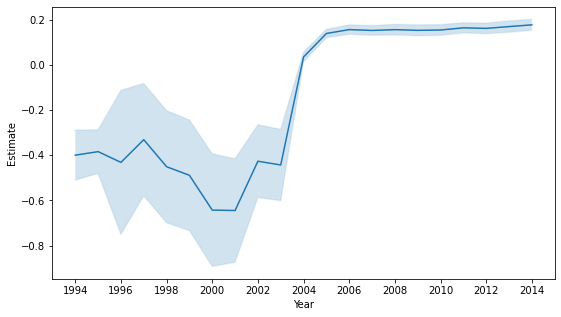

In [58]:
plot_trend_over_time()

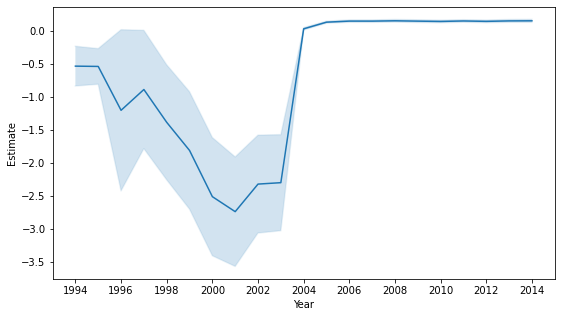

In [59]:
plot_trend_over_time(y="WAGES_SALARIES")

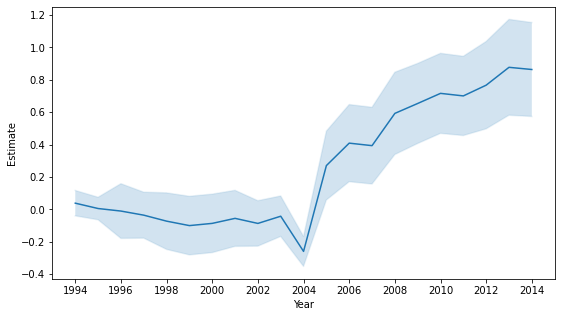

In [60]:
plot_trend_over_time(y="DIVIDENDS")

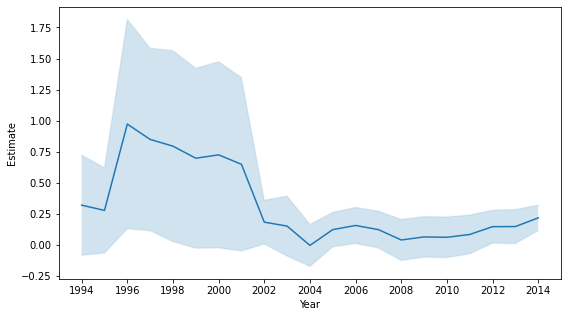

In [61]:
plot_trend_over_time(y="INTEREST")

## Propensity Score Matching